In [0]:
import numpy as np
from tqdm import tqdm_notebook
from scipy.special import softmax

import torch

import sys
sys.path.append('../Tools')
from Metrics import full_report
from DataBuilder import read_data, user_builder, separate_data, prepare_data

from Model import Model

import yaml

import warnings
warnings.filterwarnings("ignore")

In [3]:
# Reading the config file, and loading and preparing data

with open('config.yml', 'r') as file:
    config = yaml.safe_load(file)

train_data, dev_data, test_data = separate_data(user_builder(read_data('../Data/city_search.json')))
train_dl, dev_dl, test_dl, vocab, class_weight = prepare_data(train_data, dev_data, test_data, batch_size=config['batch_size'], power=config['power'])

vocab_size = len(vocab)
n_out = vocab_size

-----------------------------------------------------------
Epoch = 1

Train:
+----------+----------+-------------+--------------+--------+--------+
| Accuracy | Macro-F1 | Weighted-F1 | Average Rank | Hit@5  | MRR@5  |
+----------+----------+-------------+--------------+--------+--------+
|  41.430  |  1.597   |    32.554   |    8.512     | 41.059 | 22.168 |
+----------+----------+-------------+--------------+--------+--------+

Dev:
+----------+----------+-------------+--------------+--------+--------+
| Accuracy | Macro-F1 | Weighted-F1 | Average Rank | Hit@5  | MRR@5  |
+----------+----------+-------------+--------------+--------+--------+
|  45.250  |  1.337   |    31.639   |    4.975     | 55.435 | 31.134 |
+----------+----------+-------------+--------------+--------+--------+




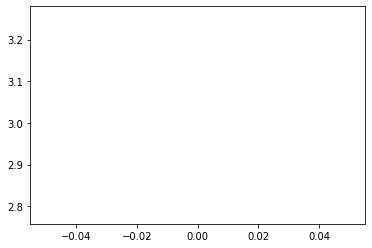

KeyboardInterrupt: ignored

In [4]:
# Initializing and training the model

if config['gpu']:
    model = Model(vocab_size, config['embedding_dim'], config['hidden_type'], config['n_hidden'], config['n_layers'], n_out, config['dropout'], config['embedding_dropout'], config['use_country']).cuda()
else:
    model = Model(vocab_size, config['embedding_dim'], config['hidden_type'], config['n_hidden'], config['n_layers'], n_out, config['dropout'], config['embedding_dropout'], config['use_country'])

model.fit(train_dl, dev_dl, class_weight=class_weight, epochs=config['epochs'], learning_rate=config['learning_rate'], weight_decay=config['weight_decay'], clipping=config['clipping'])

In [34]:
# Making predictions on the test data using the trained model and reporting performance

model.eval()

y_true_test = list()
y_pred_test = list()
y_prob_test = list()

for user_id, country_id, (X, lengths), (y, _), mask_tensor in tqdm_notebook(test_dl, leave = False):
          
    if config['gpu']:
        X = X.cuda()
        y = y.cuda()
        country_id = country_id.cuda()

    lengths = lengths.numpy()
                  
    pred, (_, _) = model(X, lengths, mask_tensor, country_id)
    pred = torch.cat([pred[:lengths[i], i] for i in range(len(lengths))], dim=0).view(-1, vocab_size)
    y = torch.cat([y[:lengths[i], i] for i in range(len(lengths))], dim=0).view(-1)
    pred_idx = torch.max(pred[:, 2:], dim=1)[1]
    y_true_test.append(y.cpu().data.numpy()-2)
    y_pred_test.append(pred_idx.cpu().data.numpy())
    y_prob_test.append(softmax(pred[:, 2:].cpu().data.numpy(), axis=1))

y_true_test = np.concatenate(y_true_test, axis=0)
y_pred_test = np.concatenate(y_pred_test, axis=0)
y_prob_test = np.concatenate(y_prob_test, axis=0)

print(full_report(y_true_test, y_pred_test, y_prob_test, verbose=True))

all_words = set(y_pred_test)
print('\nThe model predicts %d distinct labels on the test data:\n%s' % (len(all_words), ' - '.join([vocab.itos[i+2] for i in all_words])))

Overall Report:
+----------+----------+-------------+--------------+--------+--------+
| Accuracy | Macro-F1 | Weighted-F1 | Average Rank | Hit@5  | MRR@5  |
+----------+----------+-------------+--------------+--------+--------+
|  38.583  |  11.849  |    30.433   |    3.469     | 62.994 | 36.763 |
+----------+----------+-------------+--------------+--------+--------+

Performance on <sos>:
+----------+--------+-----------+--------+
| Accuracy |   F1   | Precision | Recall |
+----------+--------+-----------+--------+
|  73.186  | 68.023 |   61.520  | 76.063 |
+----------+--------+-----------+--------+

Scores@k:
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
|        | k = 1  | k = 2  | k = 3  | k = 4  | k = 5  | k = 6  | k = 7  | k = 8  | k = 9  | k = 10 |
+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+
| Hit@k  | 22.646 | 36.590 | 47.409 | 55.835 | 62.994 | 67.801 | 72.389 | 76.